In [1]:
%load_ext autoreload
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [2]:
print(tf.__version__)

2.0.0-alpha0


In [3]:
X_train_1 = pd.read_csv('data/dengue_features_train.csv')
y_train = pd.read_csv('data/dengue_labels_train.csv')['total_cases']
attr = list(X_train_1)
attr

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm']

## Cleaning the noisy training data

In [4]:
def bools_to_indexes(booleans):
    r = []
    for idx, x in enumerate(booleans):
        if x:
            r.append(idx)
    return r

idx = bools_to_indexes(X_train_1['weekofyear'] == 53)
y_train.drop(idx, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_train_1.drop(idx, inplace=True)
X_train_1.reset_index(drop=True, inplace=True)
X_train_1.shape

(1451, 24)

## Preparing the data

In [5]:
%autoreload
from utils.OurPipeline import create_pipeline

pipeline = create_pipeline(attr)
X_train = pipeline.fit_transform(X_train_1)
N, M = X_train.shape
N, M 

(1451, 20)

# Trying models

In [6]:
score_metric='neg_mean_absolute_error'
n_jobs=-1
iid = False
verbose_level = 2
k_folds=10 
n_iter_search=20

## Simple MLP with Scikit-Learn
* First we will try with a simple Multilayer Perceptron.
* According to the book 'Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems', applying the RELU activation function to all the hidden layers is a good idea.
* Here we will simply be searching through the different initial learning rates
* The ideal number of layers appears to be 7, however the scores are still very high.

#### Defining generic values

In [7]:
activation = 'relu'
train_algorithm = 'adam'
learn_rate_mode = 'adaptive'
learn_rate_val = 0.001
batch_size = 200
max_iter = 5000
random_n = 42
tol_val = 1e-4
n_iter_tol = 20
verb=False

early_stop=True
val_faction = 0.1

params = {
    #'hidden_layer_sizes': [sp_randint(30, 52), sp_randint(16, 30), sp_randint(4, 16)],
    'learning_rate_init': sp_uniform(1e-4, 1)
    
}

### 7-layer perceptron

In [8]:
neurons_per_layer = [20, 15, 10, 7, 5]

mlp = MLPRegressor(hidden_layer_sizes=neurons_per_layer, activation=activation, max_iter=max_iter, solver=train_algorithm, learning_rate=learn_rate_mode, batch_size=batch_size, random_state=random_n, tol=tol_val, verbose=verb, early_stopping=early_stop, validation_fraction=val_faction, n_iter_no_change=n_iter_tol)
MLP_Optimizer = RandomizedSearchCV(mlp, param_distributions=params, cv=k_folds, n_iter=n_iter_search, scoring=score_metric, n_jobs=n_jobs, verbose=verbose_level, iid=iid, return_train_score=True)
MLP_Optimizer.fit(X_train, y_train)
MLP_Optimizer.best_estimator_, MLP_Optimizer.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   25.7s finished


(MLPRegressor(activation='relu', alpha=0.0001, batch_size=200, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=[20, 15, 10, 7, 5], learning_rate='adaptive',
              learning_rate_init=0.08729830669792406, max_iter=5000,
              momentum=0.9, n_iter_no_change=20, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False), -22.15315382994808)

### 6-layer perceptron

In [9]:
neurons_per_layer = [18, 15, 11, 6]

mlp = MLPRegressor(hidden_layer_sizes=neurons_per_layer, activation=activation, max_iter=max_iter, solver=train_algorithm, learning_rate=learn_rate_mode, batch_size=batch_size, random_state=random_n, tol=tol_val, verbose=verb, early_stopping=early_stop, validation_fraction=val_faction, n_iter_no_change=n_iter_tol)
MLP_Optimizer = RandomizedSearchCV(mlp, param_distributions=params, cv=k_folds, n_iter=n_iter_search, scoring=score_metric, n_jobs=n_jobs, verbose=verbose_level, iid=iid, return_train_score=True)
MLP_Optimizer.fit(X_train, y_train)
MLP_Optimizer.best_estimator_, MLP_Optimizer.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   23.8s finished


(MLPRegressor(activation='relu', alpha=0.0001, batch_size=200, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=[18, 15, 11, 6], learning_rate='adaptive',
              learning_rate_init=0.1994901720631599, max_iter=5000, momentum=0.9,
              n_iter_no_change=20, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False),
 -20.896769284991095)

### 5-layer perceptron

In [13]:
neurons_per_layer = [15, 10, 5]

mlp = MLPRegressor(hidden_layer_sizes=neurons_per_layer, activation=activation, max_iter=max_iter, solver=train_algorithm, learning_rate=learn_rate_mode, batch_size=batch_size, random_state=random_n, tol=tol_val, verbose=verb, early_stopping=early_stop, validation_fraction=val_faction, n_iter_no_change=n_iter_tol)
MLP_Optimizer = RandomizedSearchCV(mlp, param_distributions=params, cv=k_folds, n_iter=n_iter_search, scoring=score_metric, n_jobs=n_jobs, verbose=verbose_level, iid=iid, return_train_score=True)
MLP_Optimizer.fit(X_train, y_train)
MLP_Optimizer.best_estimator_, MLP_Optimizer.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   30.9s finished


(MLPRegressor(activation='relu', alpha=0.0001, batch_size=200, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=[15, 10, 5], learning_rate='adaptive',
              learning_rate_init=0.020546480378377707, max_iter=5000,
              momentum=0.9, n_iter_no_change=20, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False), -21.200566970027445)

### 4-layer perceptron

In [14]:
neurons_per_layer = [15, 5]

mlp = MLPRegressor(hidden_layer_sizes=neurons_per_layer, activation=activation, max_iter=max_iter, solver=train_algorithm, learning_rate=learn_rate_mode, batch_size=batch_size, random_state=random_n, tol=tol_val, verbose=verb, early_stopping=early_stop, validation_fraction=val_faction, n_iter_no_change=n_iter_tol)
MLP_Optimizer = RandomizedSearchCV(mlp, param_distributions=params, cv=k_folds, n_iter=n_iter_search, scoring=score_metric, n_jobs=n_jobs, verbose=verbose_level, iid=iid, return_train_score=True)
MLP_Optimizer.fit(X_train, y_train)
MLP_Optimizer.best_estimator_, MLP_Optimizer.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   14.3s finished


(MLPRegressor(activation='relu', alpha=0.0001, batch_size=200, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=[15, 5], learning_rate='adaptive',
              learning_rate_init=0.37241539488806297, max_iter=5000,
              momentum=0.9, n_iter_no_change=20, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False), -20.65867561536846)

## Simple MLP with Keras on top of Tensorflow
* We will just try the amount of layers (6) which gave the ideal results with the Sci-kit API. 
* The first layer cannot use the activation function RELU given that the data was standardized.
* Sigmoid is okay given that its codomain is between 0 and 1 and that the RELU is linear above 0.
* The results here were not so great. There is definitly something wrong with how we are using the data. The more the model fits, the more our validation score decreases.

In [10]:
learn_rate = 0.0001
optim = optimizers.Adam(lr=learn_rate)
loss_fun = 'mae'

In [11]:
%autoreload
from utils.MLP import create_mlp
neurons_per_layer = [35, 25, 15, 10]

network = create_mlp(neurons_per_layer=neurons_per_layer, nr_of_features=M, optim_func=optim, loss_func=loss_fun)
network.summary()

from utils.print_history_loss import print_history_loss

history_fit = network.fit(X_train, y_train, epochs=500, batch_size=150, verbose=0, validation_split=0.5, shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 35)                735       
_________________________________________________________________
dense_2 (Dense)              (None, 25)                900       
_________________________________________________________________
dense_3 (Dense)              (None, 15)                390       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 2,616
Trainable params: 2,616
Non-trainable params: 0
______________________________________________________

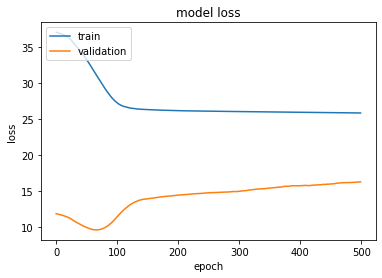

In [12]:
print_history_loss(history_fit)

## Stratified sampling
* The learning curves obtained above are very odd. The validation starts with a very small loss that starts increasing as the model overfits the training data. This is probably because the validation data is very "easy" to predict or all the same. We are going to apply stratified sampling  in order to try and fix this. Y is a continuous variable, therefore stratification is tricky.
* Stratified sampling result was absolutely what we needed as we can see in the learning curves below. It made the train and test data more similar.

In [9]:
from utils.StratifiedRegressionSampling import stratified_regression_split
X_train_strat, y_train_strat, X_test_strat, y_test_strat = stratified_regression_split(X_train, y_train, 100, 0.8)
X_train_strat.shape, y_train_strat.shape, X_test_strat.shape, y_test_strat.shape

((1160, 20), (1160,), (291, 20), (291,))

### Training the model with EarlyStopping callback
* Making the model stop training when there doesn't appear to be any improvement

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_49 (Dense)             (None, 35)                735       
_________________________________________________________________
dense_50 (Dense)             (None, 25)                900       
_________________________________________________________________
dense_51 (Dense)             (None, 15)                390       
_________________________________________________________________
dense_52 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 11        
Total params: 2,616
Trainable params: 2,616
Non-trainable params: 0
____________________________________________________

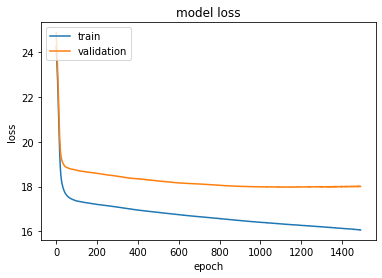

17.974709659541418

In [27]:
%autoreload
from utils.MLP import create_mlp
from utils.print_history_loss import print_history_loss

neurons_per_layer = [35, 25, 15, 10]

network = create_mlp(neurons_per_layer=neurons_per_layer, nr_of_features=M, optim_func=optim, loss_func=loss_fun)
network.summary()


early_stop = EarlyStopping(monitor='val_loss', min_delta=5e-2, patience=500, verbose=2, mode='min', restore_best_weights=True)

history_fit = network.fit(X_train_strat, y_train_strat, validation_data=(X_test_strat, y_test_strat), callbacks=[early_stop], epochs=10000, batch_size=150, verbose=0, shuffle=True)
print_history_loss(history_fit)
min(history_fit.history['val_loss'])

# Recurrent neural networks
* Here we will take advantage of the fact that we are talking about sequential data. For that reason we must **split cities** and we **can't drop rows**.

## Loading the data again
* since we dropped some rows.

In [4]:
X_train_1 = pd.read_csv('data/dengue_features_train.csv')
y_train = pd.read_csv('data/dengue_labels_train.csv')['total_cases']
attr = list(X_train_1)
attr

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm']

### Splitting the cities

In [9]:
sj = X_train_1['city'] == 'sj'
X_sj_1, y_sj = X_train_1[sj], y_train[sj]
X_iq_1, y_iq = X_train_1[-sj], y_train[-sj]

M = X_sj_1.shape[1]
X_sj_1.shape, y_sj.shape, X_iq_1.shape, y_iq.shape

((936, 24), (936,), (520, 24), (520,))

## Feature selection
* Our plan ahead isto use recurrent neural networks, but in order to have less intensive training we want to remove useless features first
* The `mlp_optim` we are using is the best from the sklearn implementations above
* We can't apply Variance threshold because our attributes have very differente range of values
* In the `f_regression` test, attributes with a p-value above 0.05 is too high and could be removed. As we can see at least 4 should clearly be removed.

### Pvalues

In [10]:
%autoreload
from utils.OurPipeline import create_pipeline
pipeline_sj = create_pipeline(attr)
X_sj = pipeline_sj.fit_transform(X_sj_1)
pipeline_iq = create_pipeline(attr)
X_iq = pipeline_iq.fit_transform(X_iq_1)
X_sj.shape, X_iq.shape

/Users/miguellobo/Development/UMinho-AA2/.env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/miguellobo/Development/UMinho-AA2/.env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


((936, 20), (520, 20))

In [29]:
from sklearn.feature_selection import SelectKBest, f_regression

epsilon = 1e-2

n_iq = sum(f_regression(X_iq, y_iq)[1] > epsilon)
n_sj = sum(f_regression(X_sj, y_sj)[1] > epsilon)
n_sj, n_iq

(8, 12)

#### Removal

In [30]:
%autoreload
from utils.OurPipeline import create_pipeline
pipeline_sj = create_pipeline(attr, k_best=M - n_sj)
X_sj = pipeline_sj.fit_transform(X_sj_1, y_sj)

pipeline_iq = create_pipeline(attr, k_best=M - n_iq)
X_iq = pipeline_iq.fit_transform(X_iq_1, y_iq)
X_sj.shape, X_iq.shape

/Users/miguellobo/Development/UMinho-AA2/.env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/miguellobo/Development/UMinho-AA2/.env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


((936, 16), (520, 12))

#### Correlation removal
* Given that in the analysis notebook we could see there are many attributes with a lot of correlation we implemented a transformer (`CorrelationDeleter`) to remove one of each pair.

In [33]:
%autoreload
from utils.OurPipeline import create_pipeline
pipeline_sj = create_pipeline(attr, k_best=M - n_sj, threshold_corr=0.6)
X_sj = pipeline_sj.fit_transform(X_sj_1, y_sj)

pipeline_iq = create_pipeline(attr, k_best=M - n_iq, threshold_corr=0.6)
X_iq = pipeline_iq.fit_transform(X_iq_1, y_iq)
X_sj.shape, X_iq.shape

/Users/miguellobo/Development/UMinho-AA2/.env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/miguellobo/Development/UMinho-AA2/.env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


((936, 6), (520, 5))

# Loading & preparing test data

In [85]:
X_test_1 = pd.read_csv('data/dengue_features_test.csv')
print(X_test_1.shape)

(416, 24)


In [86]:
sj = X_test_1['city'] == 'sj'
X_test_sj_1 = X_test_1[sj]
X_test_iq_1 = X_test_1[-sj]

X_test_sj_1.shape, X_test_iq_1.shape

((260, 24), (156, 24))

In [87]:
X_test_sj = pipeline_sj.transform(X_test_sj_1)
X_test_iq = pipeline_iq.transform(X_test_iq_1)

n_sj = X_test_sj.shape[0]
n_iq = X_test_iq.shape[0]
m_sj = X_test_sj.shape[1]
m_iq = X_test_iq.shape[1]

X_test_sj.shape, X_test_iq.shape

((260, 6), (156, 5))

# Setting up for San Juan
## Transforming the data into time sequences for San Juan
* We had to create our own sequence generator because Keras one didn't allow multiple targets per sequence.
* The value we are using for `san_juan` is 260 because it is the number of entries for that city in the test dataset.

In [88]:
%autoreload
from utils.OurTimeSequenceGenerator import generate_time_sequence
x,y = generate_time_sequence(X_sj, y_sj, n_sj)
x.shape, y.shape

((676, 260, 6), (676, 260))

#### Stratified sample on sequence means
* As we can see in the histogram below values of y vary a lot on average, per sequence, so we applied sampling with an equal distribution of those values.

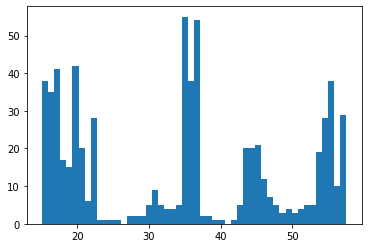

In [89]:
import matplotlib.pyplot as plt
plt.hist(np.mean(y, axis=1), bins=50)
plt.show()

In [90]:
%autoreload
from utils.StratifiedRegressionSampling import stratified_regression_split
X_sj_train_strat, y_sj_train_strat, X_sj_test_strat, y_sj_test_strat = stratified_regression_split(x, y, 50, train_size=0.5, mean=True)
X_sj_train_strat.shape, y_sj_train_strat.shape, X_sj_test_strat.shape, y_sj_test_strat.shape

((338, 260, 6), (338, 260), (338, 260, 6), (338, 260))

## Training the model
* Hyperparametrization here would definitely be too expensive.
* We obtained validation scores of little more than 10, which is very good.

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1, patience=30, verbose=2, mode='min', restore_best_weights=True)

model = Sequential()
model.add(layers.LSTM(400, input_shape=(None, X_sj_train_strat.shape[2])))
model.add(layers.Dense(350))
model.add(layers.Dense(300))
model.add(layers.Dense(n_sj, activation='relu'))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
history = model.fit(X_sj_train_strat, y_sj_train_strat, callbacks=[early_stop], batch_size=32, epochs=1000, validation_data=(X_sj_test_strat, y_sj_test_strat), verbose=0)
model.save('san_juan.h5')

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_11 (UnifiedLSTM (None, 400)               651200    
_________________________________________________________________
dense_44 (Dense)             (None, 350)               140350    
_________________________________________________________________
dense_45 (Dense)             (None, 300)               105300    
_________________________________________________________________
dense_46 (Dense)             (None, 260)               78260     
Total params: 975,110
Trainable params: 975,110
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch.
Epoch 00263: early stopping


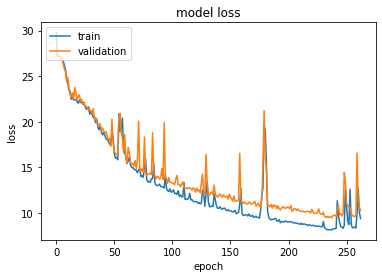

In [95]:
%autoreload
from utils.print_history_loss import print_history_loss
print_history_loss(history)

# Setting up for Iquitos
## Transforming the data into time sequences for Iquito
* We had to create our own sequence generator because Keras one didn't allow multiple targets per sequence.
* The value we are using for `iquitos` is 156 because it is the number of entries for that city in the test dataset.

In [96]:
%autoreload
from utils.OurTimeSequenceGenerator import generate_time_sequence
x,y = generate_time_sequence(X_iq, y_iq, n_iq)
x.shape, y.shape

((364, 156, 5), (364, 156))

#### Stratified sample on sequence means
* As we can see in the histogram below values of y vary a lot on average, per sequence, so we applied sampling with an equal distribution of those values.

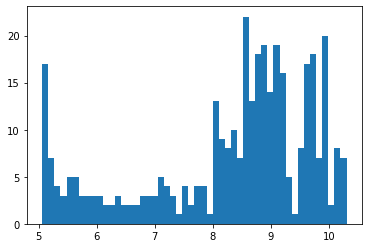

In [97]:
import matplotlib.pyplot as plt
plt.hist(np.mean(y, axis=1), bins=50)
plt.show()

In [98]:
%autoreload
from utils.StratifiedRegressionSampling import stratified_regression_split
X_iq_train_strat, y_iq_train_strat, X_iq_test_strat, y_iq_test_strat = stratified_regression_split(x, y, 50, train_size=0.5, mean=True)
X_iq_train_strat.shape, y_iq_train_strat.shape, X_iq_test_strat.shape, y_iq_test_strat.shape

((182, 156, 5), (182, 156), (182, 156, 5), (182, 156))

## Training the model
* Hyperparametrization here would definitely be too expensive.
* We obtained validation scores of little more than 4, which is really great.

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1, patience=30, verbose=2, mode='min', restore_best_weights=True)

model = Sequential()
model.add(layers.LSTM(300, input_shape=(None, X_iq_train_strat.shape[2])))
model.add(layers.Dense(250))
model.add(layers.Dense(200))
model.add(layers.Dense(n_iq, activation='relu'))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
history = model.fit(X_iq_train_strat, y_iq_train_strat, callbacks=[early_stop], batch_size=32, epochs=2000, validation_data=(X_iq_test_strat, y_iq_test_strat), verbose=0)
model.save('iquitos.h5')

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_12 (UnifiedLSTM (None, 300)               367200    
_________________________________________________________________
dense_47 (Dense)             (None, 250)               75250     
_________________________________________________________________
dense_48 (Dense)             (None, 200)               50200     
_________________________________________________________________
dense_49 (Dense)             (None, 156)               31356     
Total params: 524,006
Trainable params: 524,006
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch.
Epoch 00192: early stopping


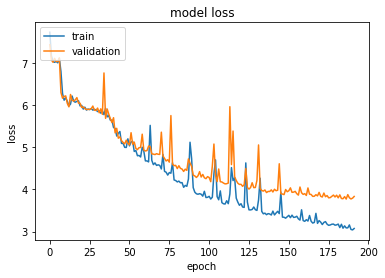

In [100]:
%autoreload
from utils.print_history_loss import print_history_loss
print_history_loss(history)

# Submit
* This submission resulted in a score of 27 (MAE). It's more than expected given the validation scores obtained above.

In [101]:
model_sj = load_model('san_juan.h5')
model_iq = load_model('iquitos.h5')

In [102]:
pred_sj = model_sj.predict(X_test_sj.reshape(-1, n_sj, m_sj))[0].tolist()
pred_iq = model_iq.predict(X_test_iq.reshape(-1, n_iq, m_iq))[0].tolist()

In [103]:
pred = pred_sj + pred_iq
pred = list(map(lambda x: int(np.round(x)), pred))
len(pred)

416

In [104]:
submit = pd.DataFrame(pred, columns=['total_cases'])
x_3 = X_test_1.iloc[:,:3].copy()
submit = pd.concat([x_3, submit], axis=1)
submit.to_csv('data/submit.csv', index=False)

### Identifying the problem
* As you can see below, given that the model was not aware of the y in the week previous to the beginning of the sequence, there's a big gap in the beggining of the predicted sequences.
* The ideal solution would be to also provide information about the previous week number of infected.

In [115]:
y_sj[-1:]

935    5
Name: total_cases, dtype: int64

In [114]:
pred_sj[0]

12.094279289245605